# TSP (巡回セールスマン問題)

ここでは、[[Andrew Lucas, 2013]](https://arxiv.org/abs/1302.5843) に沿って TSP をイジング模型で定式化し、シミュレーティッドアニーリングと量子アニーリングで解いてみます。

In [1]:
%matplotlib inline

import collections
import time

import matplotlib.pyplot as plt
import numpy as np

import anneal
from anneal.models import ClassicalIsingModel, QuantumIsingModel
from anneal.annealers import SimulatedAnnealer, QuantumAnnealer

まずは、距離関数と各種重みを構築する関数を定義します。

In [2]:
POSITIONS = np.array((
    (24050.0000, 123783),
    (24216.6667, 123933),
    (24233.3333, 123950),
    (24233.3333, 124016),
    (24250.0000, 123866),
    (24300.0000, 123683),
    (24316.6667, 123900),
))

In [3]:
def dist(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(((a - b)**2).sum())

def build_weights(positions, coeff=1):
    n_cities = len(positions)

    j = collections.defaultdict(int)
    max_dist = 0
    for t in range(n_cities):
        for a in range(n_cities):
            for b in range(n_cities):
                d = dist(positions[a], positions[b])
                max_dist = d if max_dist < d else max_dist
                j[t, a, (t + 1)%n_cities, b] = -d

    A = max_dist * coeff
    for t in range(n_cities):
        for a in range(n_cities):
            for b in range(n_cities):
                if a != b:
                    j[t, a, t, b] -= 2*A

    for a in range(n_cities):
        for t1 in range(n_cities):
            for t2 in range(n_cities):
                if t1 != t2:
                    j[t1, a, t2, a] -= 2*A

    h = np.zeros((n_cities, n_cities))
    for t in range(n_cities):
        for a in range(n_cities):
            h[t, a] += 2*A

    c = -2*A*n_cities
    return j, h, c

コールバック関数を定義

In [4]:
class Callback(object):
    def __init__(self):
        self.history = []
        
    def __call__(self, annealer, state_is_updated, model_is_updated):
        objective_value = annealer.model.objective_value()
        self.history.append(objective_value)
        if annealer.iter_count % 500 == 0:
            if isinstance(annealer.model, QuantumIsingModel):
                state = annealer.model.observe_best()
            else:
                state = annealer.model.state
            print("{}: {}'th iter, beta: {}, gamma: {}, objective_value: {}, is_valid: {}".format(
                annealer.__class__.__name__,
                annealer.iter_count,
                annealer.model.beta,
                annealer.model.__dict__.get('gamma', 0),
                objective_value,
                self.check_constraints(state)
            ))
            
    def check_constraints(self, state):
        return (
            (state.to_array().sum(axis=1) == 1).all()
            and (state.to_array().sum(axis=0) == 1).all()
        )


In [5]:
j, h, c = build_weights(POSITIONS)

In [6]:
c_history = []
min_energy = float('inf')
best_annealer = None
iter = 0
start = time.time()
for i in range(16):
    print('{}th challenge.'.format(i))
    callback = Callback()
    c_model = ClassicalIsingModel(j, h, c,  state_shape=h.shape, beta=1)
    c_annealer = SimulatedAnnealer(c_model)
    c_annealer.anneal(iter_callback=callback)
    c_history.append(callback.history)
    energy = c_model.objective_value()
    iter += c_annealer.iter_count
    if energy < min_energy:
        min_energy = energy
        best_annealer = c_annealer

best_model = best_annealer.model
print('annealing time: {}'.format(time.time() - start))
print('annealer: {}'.format(best_annealer))
print('iterations(average): {}'.format(iter/16))
print('objective: {}'.format(best_model.objective_value()))
print('state: {}'.format(best_model.state.to_array()))

0th challenge.
SimulatedAnnealer: 500'th iter, beta: 1.0515357128133505, gamma: 0, objective_value: 1246.8172458635272, is_valid: True
SimulatedAnnealer: 1000'th iter, beta: 1.105727355321881, gamma: 0, objective_value: 1246.8172458635272, is_valid: True
1th challenge.
SimulatedAnnealer: 500'th iter, beta: 1.0515357128133505, gamma: 0, objective_value: 1264.0005267119795, is_valid: True
SimulatedAnnealer: 1000'th iter, beta: 1.105727355321881, gamma: 0, objective_value: 1264.0005267119795, is_valid: True
2th challenge.
SimulatedAnnealer: 500'th iter, beta: 1.0515357128133505, gamma: 0, objective_value: 1217.9205066532322, is_valid: True
SimulatedAnnealer: 1000'th iter, beta: 1.105727355321881, gamma: 0, objective_value: 1217.9205066532322, is_valid: True
3th challenge.
SimulatedAnnealer: 500'th iter, beta: 1.0515357128133505, gamma: 0, objective_value: 1379.2260224997017, is_valid: True
SimulatedAnnealer: 1000'th iter, beta: 1.105727355321881, gamma: 0, objective_value: 1379.2260224997

In [7]:
start = time.time()
callback = Callback()
q_model = QuantumIsingModel(j, h, c, state_shape=h.shape, n_trotter=16)
q_annealer = QuantumAnnealer(q_model)
q_annealer.anneal(iter_callback=callback)
observed = q_model.observe_best()
print('annealing time: {}'.format(time.time() - start))
print('annealer: {}'.format(q_annealer))
print('iterations: {}'.format(q_annealer.iter_count))
print('objective: {}'.format(q_model.objective_value()))
print('best state: {}'.format(observed.to_array()))
print('energy of observed: {}'.format(c_model.energy(observed)))

QuantumAnnealer: 500'th iter, beta: 1000.0, gamma: 0.36787944117144233, objective_value: 990.666361143325, is_valid: True
QuantumAnnealer: 1000'th iter, beta: 1000.0, gamma: 0.36787944117144233, objective_value: 990.666361143325, is_valid: True
annealing time: 9.596693992614746
annealer: QuantumAnnealer(model=QuantumIsingModel(j=defaultdic..., h=[[ 679.215..., c=-4754.509015894542, state=QUBOState(sigma=np.array((7, 7)), classical_state_class=<class 'anneal.models.classicalisingmodel.ClassicalIsingModel.QUBOState'>), beta=1000.0, gamma=0.35656746362980823, neighbor_size=1), beta_factor=1.0, gamma_factor=0.99, freeze_limit=1000, 
iterations: 1307
objective: 990.666361143325
best state: [[0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]]
energy of observed: 990.666361143325


In [8]:
def plot_route(state, positions):
    route = [positions[np.argmax(row)] for row in state.to_array()]
    route.append(route[0])
    route = np.array(route)
    
    d = 0
    for i in range(1, len(route)):
        d += dist(route[i - 1], route[i])
    print(d)
    plt.plot(route[:, 0], route[:, 1], '-o')

Simulated Annealing
1095.92640444


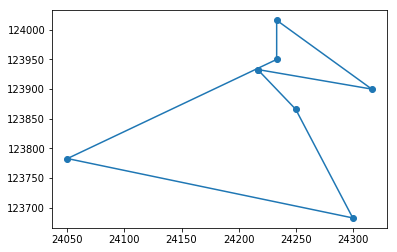

Quantum Annealing
990.666361143


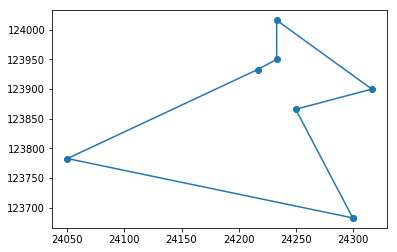

In [9]:
print('Simulated Annealing')
plot_route(best_model.state, POSITIONS)
plt.show()
print('Quantum Annealing')
plot_route(observed, POSITIONS)
plt.show()